In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


df = pd.read_csv('Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [2]:
df.shape

(2200, 8)

In [3]:
df.isna().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


In [4]:
df.nunique()

,0
N,137
P,117
K,73
temperature,2200
humidity,2200
ph,2200
rainfall,2200
label,22


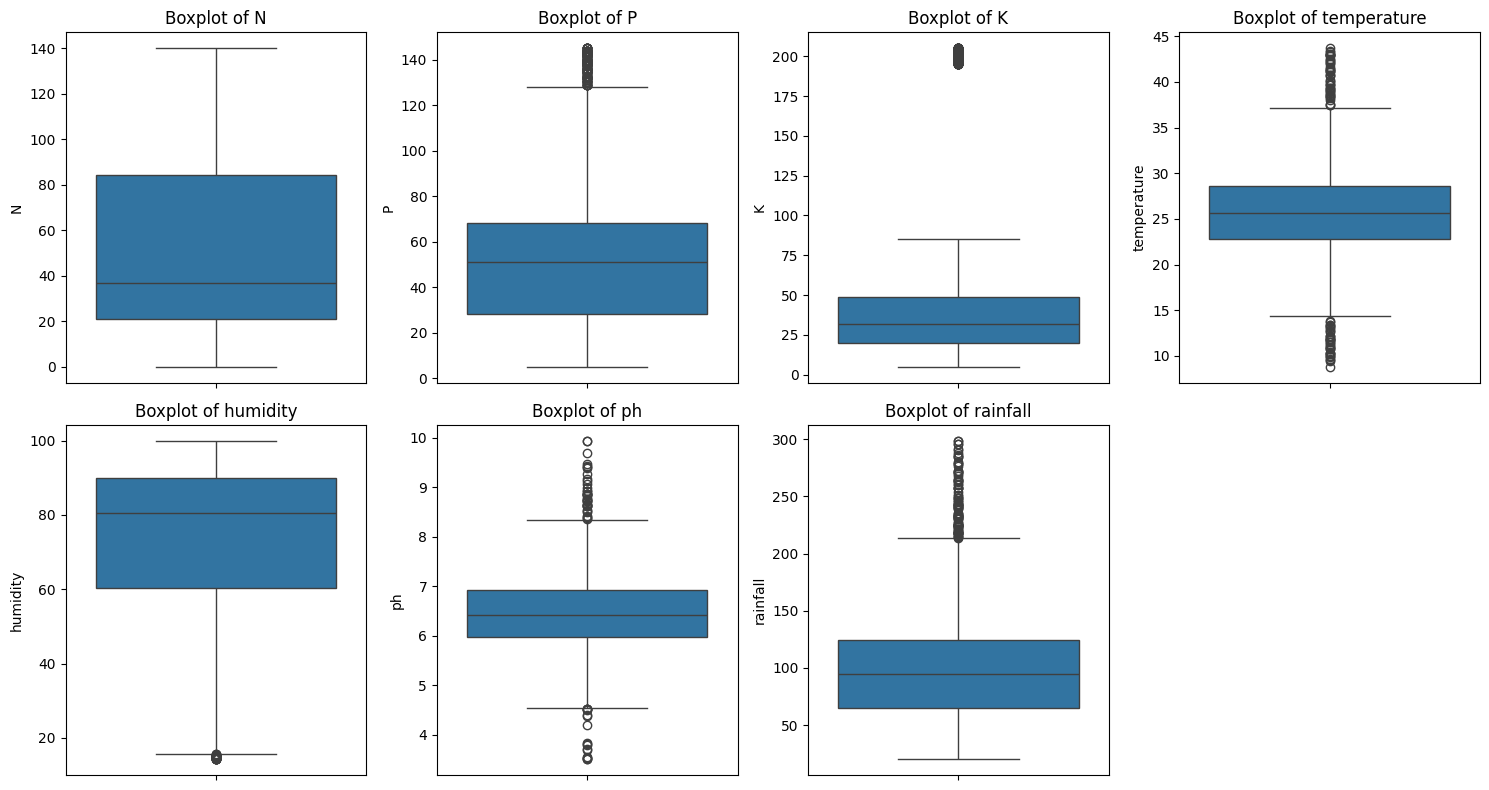

In [5]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

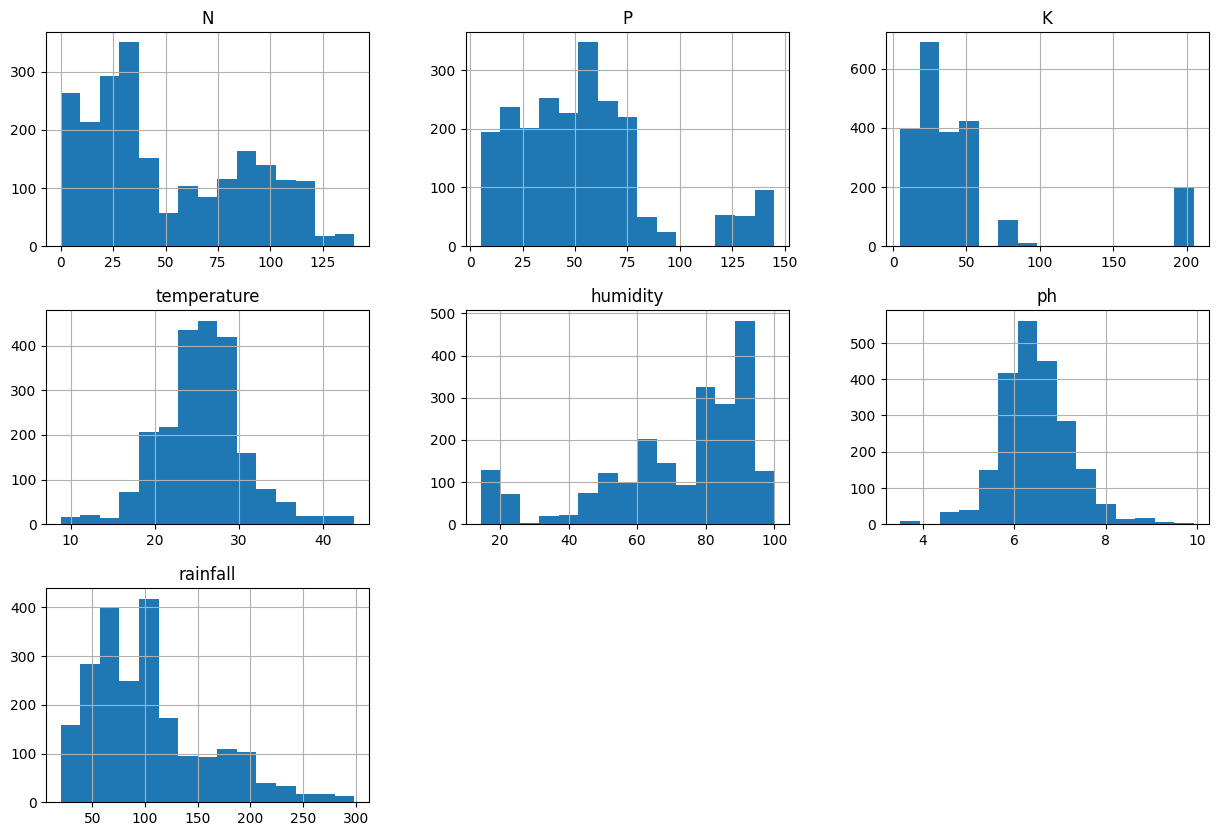

In [6]:
df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']].hist(bins=15, figsize=(15, 10))
plt.show()

In [7]:
numeric_data = df.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
corr_matrix

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
P,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
K,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


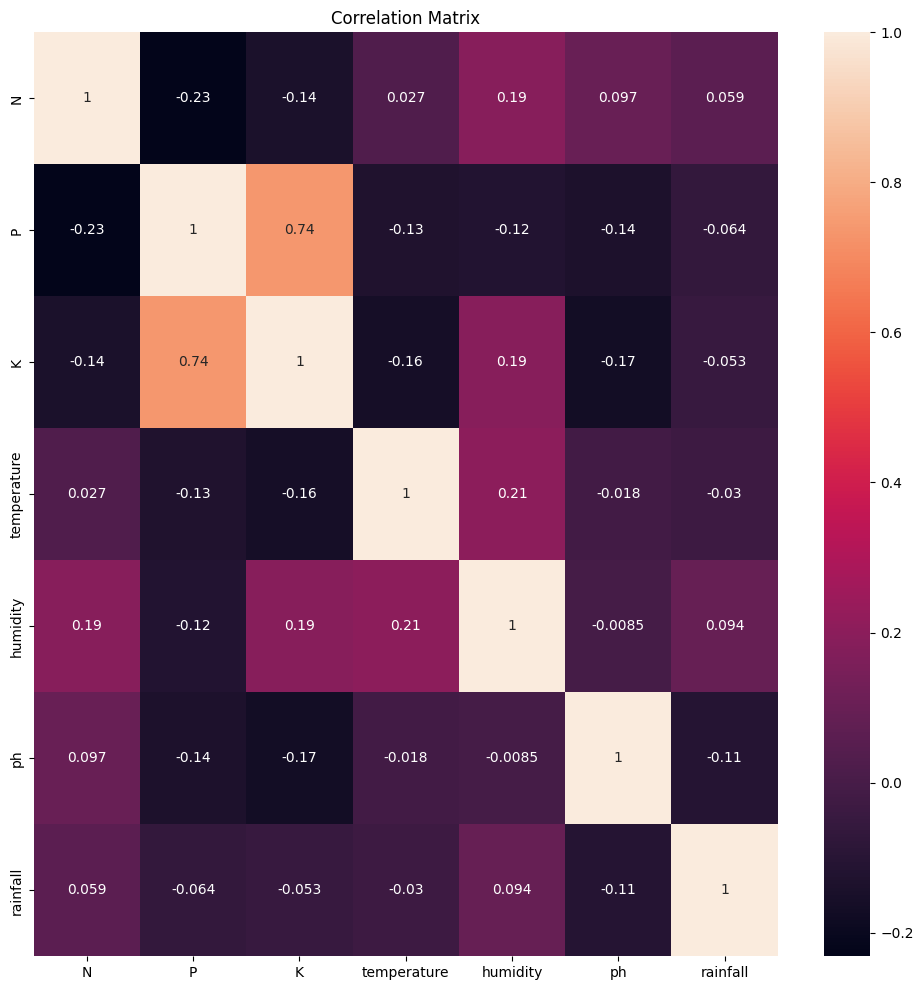

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

# Preprocessing data

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

# Transformers
label_encoder = LabelEncoder()
df['crop'] = label_encoder.fit_transform(df['label'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']])
X = pd.DataFrame(scaled_features, columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])
y = df['label']
print(X)
print(y)

             N         P         K  temperature  humidity        ph  rainfall
0     1.068797 -0.344551 -0.101688    -0.935587  0.472666  0.043302  1.810361
1     0.933329  0.140616 -0.141185    -0.759646  0.397051  0.734873  2.242058
2     0.255986  0.049647 -0.081939    -0.515898  0.486954  1.771510  2.921066
3     0.635298 -0.556811 -0.160933     0.172807  0.389805  0.660308  2.537048
4     0.743673 -0.344551 -0.121436    -1.083647  0.454792  1.497868  2.898373
...        ...       ...       ...          ...       ...       ...       ...
2195  1.529390 -0.587134 -0.318922     0.228814 -0.227709  0.401395  1.352437
2196  1.312641 -1.163269 -0.417666     0.355720 -0.666947 -0.494413  0.445183
2197  1.827421 -0.617457 -0.358420    -0.293218 -0.191235 -0.138120  1.271418
2198  1.800327 -0.647780 -0.279425     0.129612 -0.869518  0.373904  0.431545
2199  1.448109 -1.072300 -0.358420    -0.397667 -0.498020  0.401096  0.682005

[2200 rows x 7 columns]
0         rice
1         rice
2        

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Descision Tree

In [11]:
import math
from collections import Counter



In [12]:
def entropy(data):
    labels = [row[-1] for row in data]  # giả định nhãn ở cột cuối
    total = len(labels) # lấy số lượng cột chứa giá trị nhãn
    label_counts = Counter(labels) # đếm tần số cho mỗi nhãn riêng biệt (ở đây có 22 nhãn)
    return -sum((count / total) * math.log2(count / total) for count in label_counts.values()) # Tiến hành tính entropy dựa trên mảng tần số

def split_data_discrete(data, index, value):
    return [row for row in data if row[index] == value] # ?? wtf

def split_data_continuous(data, index, threshold):
    left = [row for row in data if row[index] <= threshold] # tách các điểm dữ liệu có giá trị nhỏ hơn ngưỡng threshold
    right = [row for row in data if row[index] > threshold] # tách các điểm dữ liệu có giá trị lớn hơn ngưỡng threshold
    return left, right

def info_gain(data, subsets):
    total_entropy = entropy(data) #tính entropy
    total_len = len(data) # kích thước data
    # tính gain information
    weighted_entropy = sum((len(subset) / total_len) * entropy(subset) for subset in subsets)
    return total_entropy - weighted_entropy

def split_info(subsets, total_len):
    return -sum((len(subset) / total_len) * math.log2(len(subset) / total_len)
                for subset in subsets if len(subset) > 0)

def gain_ratio(data, index, is_continuous=False):
    best_gain_ratio = -1
    best_split = None
    best_subsets = None
    total_len = len(data)

    if is_continuous:
        values = sorted(set(row[index] for row in data))
        thresholds = [(v1 + v2) / 2 for v1, v2 in zip(values[:-1], values[1:])]
        for threshold in thresholds:
            left, right = split_data_continuous(data, index, threshold)
            if not left or not right:
                continue
            gain = info_gain(data, [left, right])
            si = split_info([left, right], total_len)
            ratio = gain / si if si != 0 else 0
            if ratio > best_gain_ratio:
                best_gain_ratio = ratio
                best_split = threshold
                best_subsets = [left, right]
    else:
        values = set(row[index] for row in data)
        subsets = [split_data_discrete(data, index, val) for val in values]
        gain = info_gain(data, subsets)
        si = split_info(subsets, total_len)
        ratio = gain / si if si != 0 else 0
        best_gain_ratio = ratio
        best_split = None
        best_subsets = subsets

    return best_gain_ratio, best_split, best_subsets
class Node:
    def __init__(self, feature=None, threshold=None, children=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.children = children or {}
        self.label = label

def majority_label(data):
    # Rút ra các nhãn của data
    labels = [row[-1] for row in data]
    # Trả về nhãn có tần số xuất hiện là lớn nhất
    return Counter(labels).most_common(1)[0][0]

def build_tree(data, features, is_continuous_list):
    # Rút ra các nhãn của data
    labels = [row[-1] for row in data]


    # Nếu labels chỉ có một giá trị riêng biệt duy nhất (tất cả giá trị trong mảng giống nhau), ta đặt giá trị đó làm nhãn và kết thúc nhánh cây này
    if len(set(labels)) == 1:
        return Node(label=labels[0])
    if not features: # ???
        return Node(label=majority_label(data))

    best_attr = -1
    best_ratio = -1
    best_split_val = None
    best_subsets = None

    for i, feature in enumerate(features):
        ratio, split_val, subsets = gain_ratio(data, feature, is_continuous_list[i])
        if ratio > best_ratio:
            best_attr = feature
            best_ratio = ratio
            best_split_val = split_val
            best_subsets = subsets

    if best_ratio <= 0 or best_subsets is None:
        return Node(label=majority_label(data))

    if is_continuous_list[features.index(best_attr)]:
        left, right = best_subsets
        left_child = build_tree(left, features, is_continuous_list)
        right_child = build_tree(right, features, is_continuous_list)
        return Node(feature=best_attr, threshold=best_split_val, children={"<=": left_child, ">": right_child})
    else:
        node = Node(feature=best_attr)
        for subset in best_subsets:
            if subset:
                value = subset[0][best_attr]
                sub_features = [f for f in features if f != best_attr]
                sub_continuous = [is_continuous_list[i] for i, f in enumerate(features) if f != best_attr]
                node.children[value] = build_tree(subset, sub_features, sub_continuous)
        return node

def predict(node, row):
    while node.label is None:
        val = row[node.feature]
        if node.threshold is not None:
            node = node.children["<="] if val <= node.threshold else node.children[">"]
        else:
            node = node.children.get(val)
            if node is None:
                return None
    return node.label


is_continuous_list = [True, True, True, True, True, True, True]

train = X_train.copy()
train['label'] = y_train
train = train.values.tolist()
model = build_tree(train, [0,1,2,3,4,5,6], is_continuous_list)


print('accuracy: ', accuracy_score(y_test, [predict(model, row) for row in X_test.values.tolist()]))

accuracy:  0.9863636363636363


In [13]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state=1523)
dt_classifier.fit(X_train, y_train)

print('accuracy: ', accuracy_score(y_test, dt_classifier.predict(X_test)))

accuracy:  0.9795454545454545


# Random forest


In [14]:
import random

def bootstrap_sample(data):
    n = len(data)
    return [random.choice(data) for _ in range(n)]


In [15]:
def build_tree(data, features, is_continuous_list, max_features=None):
    labels = [row[-1] for row in data]

    if len(set(labels)) == 1:
        return Node(label=labels[0])
    if not features:
        return Node(label=majority_label(data))

    # NEW: Chọn ngẫu nhiên max_features đặc trưng để thử
    if max_features and max_features < len(features):
        selected = random.sample(list(zip(features, is_continuous_list)), max_features)
        feature_candidates, continuous_candidates = zip(*selected)
    else:
        feature_candidates, continuous_candidates = features, is_continuous_list

    best_attr = -1
    best_ratio = -1
    best_split_val = None
    best_subsets = None

    for i, feature in enumerate(feature_candidates):
        ratio, split_val, subsets = gain_ratio(data, feature, continuous_candidates[i])
        if ratio > best_ratio:
            best_attr = feature
            best_ratio = ratio
            best_split_val = split_val
            best_subsets = subsets

    if best_ratio <= 0 or best_subsets is None:
        return Node(label=majority_label(data))

    if is_continuous_list[features.index(best_attr)]:
        left, right = best_subsets
        left_child = build_tree(left, features, is_continuous_list, max_features)
        right_child = build_tree(right, features, is_continuous_list, max_features)
        return Node(feature=best_attr, threshold=best_split_val, children={"<=": left_child, ">": right_child})
    else:
        node = Node(feature=best_attr)
        for subset in best_subsets:
            if subset:
                value = subset[0][best_attr]
                sub_features = [f for f in features if f != best_attr]
                sub_continuous = [is_continuous_list[i] for i, f in enumerate(features) if f != best_attr]
                node.children[value] = build_tree(subset, sub_features, sub_continuous, max_features)
        return node


In [16]:
def build_forest(data, n_trees, features, is_continuous_list, max_features=None):
    forest = []
    for _ in range(n_trees):
        sample = bootstrap_sample(data)
        tree = build_tree(sample, features, is_continuous_list, max_features)
        forest.append(tree)
    return forest


In [17]:
from collections import Counter

def forest_predict(forest, row):
    predictions = [predict(tree, row) for tree in forest]
    predictions = [p for p in predictions if p is not None]
    if not predictions:
        return None
    return Counter(predictions).most_common(1)[0][0]


In [19]:
train = X_train.copy()
train['label'] = y_train
train = train.values.tolist()

forest = build_forest(train, n_trees=20, features=[0,1,2,3,4,5,6], is_continuous_list=is_continuous_list, max_features=3)

y_pred = [forest_predict(forest, row) for row in X_test.values.tolist()]
print('Random Forest accuracy:', accuracy_score(y_test, y_pred))


Random Forest accuracy: 0.9931818181818182


# Thư viện


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Tạo mô hình
rf = RandomForestClassifier(
    n_estimators=20,      # số lượng cây
    max_features='sqrt',   # số đặc trưng ngẫu nhiên mỗi lần split (sqrt là mặc định)
    bootstrap=True,        # bật bootstrapping
    random_state=42        # cố định seed để tái lập kết quả
)

# 2. Huấn luyện
rf.fit(X_train, y_train)

# 3. Dự đoán
y_pred = rf.predict(X_test)

# 4. Đánh giá
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.990909090909091
